In [ ]:
Name: Tian Liu
UIN: 525004380

### Solution Explanation:

In this project, I implemented the Transformer archetecture for Machine Translation task. Basically, I split the given training data into train and validation set with ratio of 0.75:0.15. Then I tuned the model parameters using the validation set. Finally, the transformer is trained on the entire dataset given. And the final model is then saved and submitted for testing.

Notice that the trained model are saved by weights, and loaded by weights for testing. For more instructions on how to run the trained model on testing data, please refer to the laset section `To test the trained model on the testing data` at the end of the script.

In [ ]:
!nvidia-smi

Tue Apr 26 02:02:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation/'

/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation


### Load Training Data

In [ ]:
import pickle
import numpy as np

train_input = pickle.load(open('DS_5_train_input', 'rb'))
train_output = pickle.load(open('DS_5_train_output', 'rb'))

# check dimension
print(type(train_input), type(train_input[0]), len(train_input))
print(type(train_output), type(train_output[0]), len(train_output))

# get the max num of words in train input and output to determine sequence_length
# get the max length of a word to determine vocabulary size

max_ct = 0
max_len = 0
vocab_set = set()
for text in train_input:
  ct = len(text.split())
  for word in text.split():
    vocab_set.add(word)
    length = len(word)
    max_len = max(max_len, length)
  max_ct = max(max_ct, ct)

print('vocab_size in train_input:', len(vocab_set))
print('max num of words in train_input:', max_ct)
print('max length of a word in train_input:', max_len)
print()

max_ct = 0
max_len = 0
vocab_set = set()
for text in train_output:
  ct = len(text.split())
  for word in text.split():
    vocab_set.add(word)
    length = len(word)
    max_len = max(max_len, length)  
  max_ct = max(max_ct, ct)

print('vocab_size in train_output:', len(vocab_set))
print('max num of words in train_output:', max_ct)
print('max length of a word in train_output:', max_len)

<class 'list'> <class 'str'> 5000
<class 'list'> <class 'str'> 5000
vocab_size in train_input: 11
max num of words in train_input: 64
max length of a word in train_input: 1

vocab_size in train_output: 34
max num of words in train_output: 95
max length of a word in train_output: 2


#### Preprocess Data

In [ ]:
# insert [start] and [end] to the output language

text_pairs = []
for i in range(len(train_input)):
  input = train_input[i]
  output = "[start] " + train_output[i].strip() + " [end]" # strip off the whitespaces
  text_pairs.append((input, output))

In [ ]:
# check sample text pairs
from numpy import random

num_sample = 10
idx = [random.randint(0, len(train_input)) for i in range(num_sample)]

for i in idx:
  print("idx =", i)
  print(len(text_pairs[i][0].split()), text_pairs[i][0])
  print("->")
  print(len(text_pairs[i][1].split())-2, text_pairs[i][1])
  print()

idx = 2349
46 a k c g a d a e c e a e a i a f a i c f a k b g c g a e c d a i b g b d c e c g a d c g b g 
->
68 [start] c g c e a e e c f b g c g a k h i c d a e k a i g j l b g b d c e a i ed ee ef a f m eg c g c g b g a d ej ek a i eh ei el a e em a d f fd a k d fe [end]

idx = 2034
40 a h a d a f c d c f a g b e a i a h b f a d b d c g c e b g a f c e b g c e c g 
->
59 [start] c d c f a f d e b e b f b d c g a d i j c e a h h k l b g c e b g a f ee ef a i m ed eg a g g eh a d f ei c e c g a h ej ek el [end]

idx = 610
40 a k a e a j a f b d a e c e b f a e a d b d a g a k c e a k b f b e a e b g b e 
->
59 [start] b d c e a e e a f d f b f b d c e b f b e a k k l a k j m b g a e ee a g ed ef a d i eg a e eh a j g h ei a e ej b e a k ek el [end]

idx = 2639
34 a i c g a j c d a d a j b d a g c e c f c d a f a e b g b f c f b f 
->
50 [start] c g c d b d c e c f a g g h c d a j f i j b g a e l b f a f m ed a d k ee c f a j e ef eg b f a i d eh ei [end]

idx = 4822
54 a f a h c d a e

#### Split training data into train and val set

In [ ]:
import random

random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:]

print(len(train_pairs))
print(len(val_pairs))

4250
750


In [ ]:
# save text_pairs
import pickle

with open('text_pairs', "wb") as out_file:
  pickle.dump(text_pairs, out_file)

# with open('train_pairs', "wb") as out_file:
#   pickle.dump(train_pairs, out_file)

# with open('val_pairs', "wb") as out_file:
#   pickle.dump(val_pairs, out_file)

#### Vectorizing the input and output text pairs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import string
import re

strip_chars = string.punctuation
# print(type(strip_chars))

strip_chars = strip_chars.replace("[", "") # will keep [start] and [end] as it is to separate the marker from actual word start and end
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "") # replace punctuation characters with the empty string

input_vocab_size = 100
output_vocab_size = 100

sequence_length = 100 # max seq length seen in train data is 95

source_vectorization = layers.TextVectorization(
    max_tokens=input_vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=output_vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_input_texts = [pair[0] for pair in text_pairs] # here use all given training data
train_output_texts = [pair[1] for pair in text_pairs]

source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

print(len(source_vectorization.get_vocabulary()))
print(len(target_vectorization.get_vocabulary()))

13
38


#### Preparing datasets for the translation task

In [ ]:
batch_size = 64

def format_dataset(input, output):
    input = source_vectorization(input)
    output = target_vectorization(output)
    return ({
        "input": input,
        "output": output[:, :-1],
      }, output[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

print(type(val_ds))

for inputs, targets in train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'>
inputs['input'].shape: (64, 100)
inputs['output'].shape: (64, 100)
targets.shape: (64, 100)


### Use Transformer for Machine Translation

#### Transformer Encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### Using positional encoding to re-inject order information

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Transformer Decoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Text Decoder

In [ ]:
import numpy as np

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100

def strip_markers(sentence):
  # strip the leading [start] and tailing [end] if existing

  words = sentence.split()
  if words[0] == "[start]":
    clean_words = words[1:]
  else:
    clean_words = words
  
  if clean_words[-1] == "[end]":
    clean_words = clean_words[:-1]
  else:
    clean_words = clean_words

  clean_text = " ".join(clean_words)
  return clean_text

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence

#### End-to-end Transformer

In [ ]:
embed_dim = 128
dense_dim = 512
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, input_vocab_size, embed_dim)(encoder_inputs)
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x) # stack up transformerencoder layers
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
# x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, input_vocab_size, embed_dim)(decoder_inputs)
# x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(output_vocab_size, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

#### Train the sequence-to-sequence Transformer

In [ ]:
# check how the accuracy metric is calculated in Keras
import tensorflow as tf

m = tf.keras.metrics.Accuracy()
m.update_state([[1,100], [2, 200]], [[1, 200], [3, 300]])
m.result().numpy()

0.25

In [ ]:
import tensorflow as tf

# turns out the Keras metric acc is very close to the word accuracy, no need for customied callbacks
"""
def calculate_word_acc(target_texts, pred_texts):

  total_ct = 0
  match_ct = 0

  assert(len(target_texts)==len(pred_texts)) # assert target sentence number match pred sentence number
  
  text_pairs = zip(target_texts, pred_texts) 
  for pair in text_pairs: # loop through each sentence
    target = pair[0]
    pred = pair[1]

    target_words = target.split()
    pred_words = pred.split()

    total_ct += len(target_words)
    min_len = min(len(target_words), len(pred_words))
    
    for i in range(min_len): # loop through each word
      if target_words[i] == pred_words[i]:
        match_ct += 1
    
  word_acc = match_ct / total_ct
  return word_acc


train_word_acc = []
val_word_acc = []

# define customized metric as callback function, but very slow
class WordAccuracy(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs):
        self.train_word_acc = 0 
        self.val_word_acc = 0 
    
    def on_epoch_end(self, epoch, logs):

        # train_word_acc
        # train_input_texts = [pair[0] for pair in train_pairs]
        # train_output_texts = [strip_markers(pair[1]) for pair in train_pairs]

        # train_pred_texts = []
        # for input_sentence in train_input_texts:
        #   pred_sentence = strip_markers(decode_sequence(input_sentence))
        #   train_pred_texts.append(pred_sentence)
        # self.train_word_acc = calculate_word_acc(train_output_texts, train_pred_texts)

        # val_word_acc
        val_input_texts = [pair[0] for pair in val_pairs]
        val_output_texts = [strip_markers(pair[1]) for pair in val_pairs]

        val_pred_texts = []
        for input_sentence in val_input_texts:
          pred_sentence = strip_markers(decode_sequence(input_sentence))
          val_pred_texts.append(pred_sentence)

        self.val_word_acc = calculate_word_acc(val_output_texts, val_pred_texts)

        # collect

        # train_word_acc.append(self.train_word_acc)
        val_word_acc.append(self.val_word_acc)
      
        print("train_word_auc = {:.4f}, val_word_auc = {:.4f}".format(\
              self.train_word_acc, self.val_word_acc))
"""

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

# word_auc = WordAccuracy()
# history = transformer.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[word_auc])

history = transformer.fit(train_ds, epochs=100, validation_data=val_ds, shuffle=True)

Epoch 1/100
67/67 [==============================] - 12s 67ms/step - loss: 1.6236 - accuracy: 0.2546 - val_loss: 1.1361 - val_accuracy: 0.3468
Epoch 2/100
67/67 [==============================] - 4s 56ms/step - loss: 1.2196 - accuracy: 0.3308 - val_loss: 1.0865 - val_accuracy: 0.3721
Epoch 3/100
67/67 [==============================] - 4s 55ms/step - loss: 1.1052 - accuracy: 0.3720 - val_loss: 0.9702 - val_accuracy: 0.4379
Epoch 4/100
67/67 [==============================] - 4s 55ms/step - loss: 1.0404 - accuracy: 0.4008 - val_loss: 0.9783 - val_accuracy: 0.4256
Epoch 5/100
67/67 [==============================] - 4s 55ms/step - loss: 0.9962 - accuracy: 0.4249 - val_loss: 0.9258 - val_accuracy: 0.4493
Epoch 6/100
67/67 [==============================] - 4s 60ms/step - loss: 0.9523 - accuracy: 0.4492 - val_loss: 0.9217 - val_accuracy: 0.4606
Epoch 7/100
67/67 [==============================] - 4s 55ms/step - loss: 0.9189 - accuracy: 0.4684 - val_loss: 0.8056 - val_accuracy: 0.5193
Epoch

In [ ]:
# save the trained model
transformer.save_weights('tianliu_525004380_project2_transformer_valacc_0.8862.weights') # save by weights
transformer.save('tianliu_525004380_project2_transformer_trained_valacc0.8862.model.h5') # save by h5 format
transformer.save('tianliu_525004380_project2_transformer_trained_valacc0.8862.model')

INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_trained_valacc0.8862.model/assets


INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_trained_valacc0.8862.model/assets


#### Plot the train and val performance

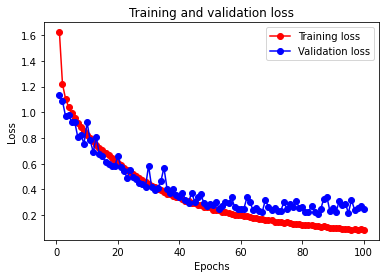

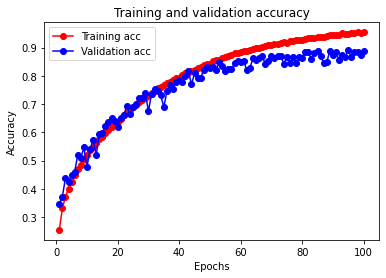

In [ ]:
# plot training and validation loss and acc

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", marker="o", label="Training loss")
plt.plot(epochs, val_loss_values, "b", marker="o",label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", marker="o", label="Training acc")
plt.plot(epochs, val_acc, "b", marker="o", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Check translation performance on val dataset

In [ ]:
# sample some sentences as test data to see performance

test_input_texts = [pair[0] for pair in val_pairs]
test_output_texts = [pair[1] for pair in val_pairs]

# test_input_texts = [pair[0] for pair in test_pairs]

from numpy import random

num_sample = 10
idx = [random.randint(0, len(val_pairs)) for i in range(num_sample)]

for i in idx:
  input_sentence = test_input_texts[i]
  target = test_output_texts[i]

  print("idx =", i)
  print("-> input")
  print(input_sentence)
  print("-> target")
  print(strip_markers(target))
  print("-> predicted")
  print(strip_markers(decode_sequence(input_sentence)))
  print()

idx = 713
-> input
a j a f c f c d c e a e a i a f a i a d c f c f a g b g c g c d a e b e a d b g a k b f c d c g 
-> target
c f c d a f d e c e c f c f a d h i b g c g a g k l c d a i j m ed b e a e ef a f ee eg b g b f c d a k ej ek a d ei el c g a i eh em fd a e fe a j f g ff
-> predicted
c f c d a f d e c e c f c f a d h i b g c g a g k l a i j m b e a f ed ee b e a e eg b g c f a d ei ej a i ef eh ek a e el a e em a j f g fd c g b g a j f ff fg

idx = 452
-> input
a j b g a f a h c f b d a h b g b g a h b f a e c d a g a f b f a k a e c d c f a k a e b e b e c g c d 
-> target
b g c f b d b g b g b f c d a e j b f c d a e m c f a k ed ee a f l ef b e a e eh b e a k ei ej a g eg ek a h i k el a h g h em a h e f fd c g a f fe ff c d a j d fg fh
-> predicted
b g c f b d b g b g b f c d a e j a h h i k c d a e m a h g l ed c f a e ef c f a k eg eh a g ee ei a h e f ej b e a f ek el b e a f em fd c g a j d fe ff c d a f fg fh

idx = 320
-> input
a j c e a d b g c d a e a f a h c e c d

### Retrain on the entire given dataset

In [ ]:
train_ds_full = make_dataset(text_pairs)

In [ ]:
embed_dim = 128
dense_dim = 512
num_heads = 8
vocab_size = 100

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds_full, epochs=80)

Epoch 1/80
79/79 [==============================] - 7s 50ms/step - loss: 1.5561 - accuracy: 0.2665
Epoch 2/80
79/79 [==============================] - 4s 49ms/step - loss: 1.1760 - accuracy: 0.3450
Epoch 3/80
79/79 [==============================] - 4s 48ms/step - loss: 1.0691 - accuracy: 0.3889
Epoch 4/80
79/79 [==============================] - 4s 50ms/step - loss: 1.0056 - accuracy: 0.4224
Epoch 5/80
79/79 [==============================] - 4s 49ms/step - loss: 0.9532 - accuracy: 0.4502
Epoch 6/80
79/79 [==============================] - 4s 49ms/step - loss: 0.9109 - accuracy: 0.4743
Epoch 7/80
79/79 [==============================] - 4s 49ms/step - loss: 0.8719 - accuracy: 0.4942
Epoch 8/80
79/79 [==============================] - 4s 50ms/step - loss: 0.8358 - accuracy: 0.5150
Epoch 9/80
79/79 [==============================] - 4s 49ms/step - loss: 0.8029 - accuracy: 0.5328
Epoch 10/80
79/79 [==============================] - 4s 49ms/step - loss: 0.7681 - accuracy: 0.5522
Epoch 11/

### Save the Final Trained Model

In [ ]:
transformer.save_weights('tianliu_525004380_project2_transformer_final_0.9290.weights')
transformer.save('tianliu_525004380_project2_transformer_final_0.9290.best.h5') # save in h5 format
transformer.save('tianliu_525004380_project2_transformer_final_0.9290.best')

INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_final_0.9290.best/assets


INFO:tensorflow:Assets written to: tianliu_525004380_project2_transformer_final_0.9290.best/assets


### To test the trained model on the testing data

#### Set up working directory

In [ ]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the following directory to your working directory
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation/'

/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project2_MachineTranslation


Upload `trained model` and `text_pairs` to the folder

#### To load the trained model

Because the trained model is saved by weights, here we loaded the model by its weights.

In [ ]:
# load the model by loading the weights

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        
        proj_output = self.dense_proj(attention_output_2)
        
        return self.layernorm_3(attention_output_2 + proj_output)

embed_dim = 128
dense_dim = 512
num_heads = 8
vocab_size = 100
sequence_length = 100

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer_loaded = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


# load the saved weights
transformer_loaded.load_weights('tianliu_525004380_project2_transformer_final_0.9290.weights')

#### To run trained model on test data

Note: before run the trained model to generate translated text for the testing data, the `source_vectorization` and `target_vectorization` have to be initialized by loading the `text_pairs`, such that the test input can be vectorized using the same training input vocabulary, and the predicted results can be decoded using the same training output vocabulary.

In [ ]:
# initialize the source_vectorization and target_vectorization

import tensorflow as tf
from tensorflow.keras import layers
import string
import re
import pickle

strip_chars = string.punctuation
# print(type(strip_chars))

strip_chars = strip_chars.replace("[", "") # will keep [start] and [end] as it is to separate the marker from actual word start and end
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "") # replace punctuation characters with the empty string

vocab_size = 100 
sequence_length = 100 # max seq length seen in train data is 95

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)


# load the train_pairs
train_pairs_loaded = pickle.load(open('text_pairs', 'rb')) 

train_input_texts = [pair[0] for pair in train_pairs_loaded]
train_output_texts = [pair[1] for pair in train_pairs_loaded]

source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

print(len(source_vectorization.get_vocabulary()))
print(len(target_vectorization.get_vocabulary()))

13
38


Load the `test_input` file and preprocess and translate it. Notice that the following decoding process would be long if the testing dataset is large.

In [ ]:
# load and preprocess the testing input data

def strip_markers(sentence):
  # strip the leading [start] and tailing [end] if existing

  words = sentence.split()
  if words[0] == "[start]":
    clean_words = words[1:]
  else:
    clean_words = words
  
  if clean_words[-1] == "[end]":
    clean_words = clean_words[:-1]
  else:
    clean_words = clean_words

  clean_text = " ".join(clean_words)
  return clean_text

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer_loaded(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence


import pickle

# load the test input data
test_input = pickle.load(open('DS_5_test_input', 'rb')) 

# For self testing purposes
# test_input_texts = [pair[0] for pair in train_pairs]
# test_output_texts = [strip_markers(pair[1]) for pair in train_pairs]

# test_input_texts = [pair[0] for pair in val_pairs]
# test_output_texts = [strip_markers(pair[1]) for pair in val_pairs]

# test_input_texts = [pair[0] for pair in train_pairs_loaded]
# test_output_texts = [strip_markers(pair[1]) for pair in train_pairs_loaded]

# test_input = test_input_texts[-20:]
# test_output = test_output_texts[-20:]

import numpy as np
from tqdm import tqdm

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100 # here we use max seq of 100

# run the trained mode to get the predicted output
test_pred = []
for test_sentence in tqdm(test_input):
  test_pred.append(strip_markers(decode_sequence(test_sentence)))

100%|██████████| 20/20 [00:54<00:00,  2.70s/it]


#### To calculate the "accuracy for words"

First load the `test_output`, then you can calculate the test accuracy using the "accuracy for words" metric (you can use your own or use my implementation below)

In [ ]:
def calculate_word_acc(target_texts, pred_texts):
  total_ct = 0
  match_ct = 0

  assert(len(target_texts)==len(pred_texts)) # assert target sentence number match pred sentence number
  
  text_pairs = zip(target_texts, pred_texts) 
  for pair in text_pairs: # loop through each sentence
    target = pair[0]
    pred = pair[1]
    print()
    print("target:", target)
    print("predic:", pred)
    
    target_words = target.split()
    pred_words = pred.split()

    total_ct += len(target_words)
    min_len = min(len(target_words), len(pred_words))
    print('target_len:', len(target_words))
    print('pred_len:', len(pred_words))
    
    m_ct = 0
    for i in range(min_len): # loop through each word
      if target_words[i] == pred_words[i]:
        m_ct += 1
        match_ct += 1
    
    print('m_ct', m_ct)
    print('match_ct', match_ct)
    print('total_ct', total_ct)
    
  word_acc = match_ct / total_ct
  return word_acc

# load the test output data
test_output = pickle.load(open('DS_5_test_output', 'rb'))

acc = calculate_word_acc(test_output, test_pred)
print("\nTesting accuracy is", acc)


target: c g b g a e e b f a i d f g c g a k h i b f a g j k b f a k l m b e b f a i ed ee ef b g b g b d a h eh ei ej b g a i eg ek el c d a f em fd a e fe
predic: c g b g a e e a k d f b f c g a i g h i b f a g j k b f a k l m b e b f a i ed ee ef b g b d b g a h eh ei ej b g a i eg ek el c d a f em fd a e fe
target_len: 68
pred_len: 68
m_ct 56
match_ct 56
total_ct 68

target: b e c g b d c d a h e f g b g c e a j h i j c e a f k l c g a g m ed b g a d ee ef b f a h d eg eh
predic: b e c g b d c d a h e f g b g c e a j h i j c e a f k l c g a g m ed b g a d ee ef b f a h d eg eh
target_len: 47
pred_len: 47
m_ct 47
match_ct 103
total_ct 115

target: b g a e d c e c f a h e f g c e b f c e b d a d k l b f b g b f a k ee ef a j m ed eg a k j eh c d c f b g a e el b d a j ek em fd c e a h ej fe ff a j i ei fg c g a e fi a f fh fj a k h fk
predic: b g a e d c e c f a h e f g b f c d b f b f a e l b d c f a k ed ee b g b e c d c g c e b f a j ej ek el a j eh ei em a k eg fd a k ef fe a k m

### For grader

####Step1: 

upload the attached `text_pairs` and `tianliu_525004380_project2_transformer_final_0.9290.weights.data-00000-of-00001` and `tianliu_525004380_project2_transformer_final_0.9290.weights.index` to your working directory

####Step 2: 

The followinng code block does the following:
* rebuild source and target vectorization from `text_pairs`
* load the pretrained model by loading its weights
* make prediction
* calculate accuracy. 

Please change the two lines of code to your `test_input` and `test_out`. Then run the following code block to get accuracy.

In [7]:
# test_input = 'grader_test_input'
# test_out = 'grader_test_output'

# model = keras.models.load_model("Your model")
# Fill in your code here, to the variable 'pre', without re-training

#-------------------------------My code

# initialize the source_vectorization and target_vectorization from `text_pairs`
import tensorflow as tf
from tensorflow.keras import layers
import string
import re
import pickle

strip_chars = string.punctuation
# print(type(strip_chars))
strip_chars = strip_chars.replace("[", "") # will keep [start] and [end] as it is to separate the marker from actual word start and end
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "") # replace punctuation characters with the empty string

vocab_size = 100 
sequence_length = 100 # max seq length seen in train data is 95

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

# load the train_pairs
train_pairs_loaded = pickle.load(open('text_pairs', 'rb')) 

train_input_texts = [pair[0] for pair in train_pairs_loaded]
train_output_texts = [pair[1] for pair in train_pairs_loaded]

source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
print("source and target vectorization rebuilt.")

print(len(source_vectorization.get_vocabulary()))
print(len(target_vectorization.get_vocabulary()))

#---------------------

# import pickle
# # load the test input data
# test_input = pickle.load(open('DS_5_train_input', 'rb'))
# test_input = test_input[:10]
# test_output = pickle.load(open('DS_5_train_output', 'rb'))
# test_out = test_output[:10]

# load the model by loading the saved weights
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        
        proj_output = self.dense_proj(attention_output_2)
        
        return self.layernorm_3(attention_output_2 + proj_output)

embed_dim = 128
dense_dim = 512
num_heads = 8
vocab_size = 100
sequence_length = 100

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer_loaded = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# load the saved weights
transformer_loaded.load_weights('tianliu_525004380_project2_transformer_final_0.9290.weights')
print("trained model loaded.")

# make prediction
def strip_markers(sentence):
  # strip the leading [start] and tailing [end] if existing

  words = sentence.split()
  if words[0] == "[start]":
    clean_words = words[1:]
  else:
    clean_words = words
  
  if clean_words[-1] == "[end]":
    clean_words = clean_words[:-1]
  else:
    clean_words = clean_words

  clean_text = " ".join(clean_words)
  return clean_text

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer_loaded(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break

    return decoded_sentence


import numpy as np
from tqdm import tqdm

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100 # here we use max seq of 100

# run the trained mode to get the predicted output
print("makinng predictions in test_input ......")
test_pred = []
for test_sentence in tqdm(test_input):
  test_pred.append(strip_markers(decode_sequence(test_sentence)))

pre = test_pred
print("\n\npredictions done.")
# pre = your_decoded_list_of_output_strings

#------------------------------- continue with grader's code, i have to modify the index_range to handle the case when the predictions is shorter than groundtruth

total = 0
correct = 0
for sen in range(len(test_out)):
    temp = test_out[sen].split()
    guess = pre[sen].split()
    # print(sen)
    # print(temp)
    # print(guess)
    index_range = min(len(temp), len(guess)) # i changed here
    for index in range(index_range): # i changed here
        cor = temp[index]
        gus = guess[index]
        if gus == cor:
            correct += 1
    total += len(temp) # i changed here
print(total)
print(correct)
acc = correct / total
print(acc)

source and target vectorization rebuilt.
13
38
trained model loaded.
makinng predictions in test_input ......


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

predictions done.
0
['b', 'f', 'c', 'f', 'b', 'f', 'c', 'd', 'a', 'j', 'e', 'f', 'g', 'c', 'e', 'b', 'g', 'a', 'k', 'i', 'j', 'b', 'd', 'b', 'f', 'a', 'k', 'l', 'm', 'b', 'f', 'b', 'd', 'a', 'h', 'ed', 'ee', 'ef', 'a', 'k', 'k', 'eg', 'a', 'k', 'h', 'eh', 'a', 'e', 'ei', 'c', 'd', 'a', 'f', 'ej', 'ek', 'a', 'g', 'd', 'el']
['b', 'f', 'c', 'f', 'b', 'f', 'c', 'd', 'a', 'j', 'e', 'f', 'g', 'c', 'e', 'b', 'g', 'a', 'k', 'i', 'j', 'b', 'd', 'b', 'f', 'a', 'k', 'l', 'm', 'b', 'f', 'b', 'f', 'a', 'h', 'ed', 'ee', 'ef', 'a', 'k', 'k', 'eg', 'a', 'k', 'h', 'eh', 'a', 'e', 'ei', 'c', 'd', 'a', 'f', 'ej', 'ek', 'a', 'g', 'd', 'el']
1
['b', 'e', 'c', 'd', 'b', 'g', 'c', 'g', 'a', 'i', 'e', 'f', 'g', 'a', 'f', 'd', 'h', 'c', 'e', 'c', 'f', 'c', 'f', 'a', 'e', 'l', 'c', 'd', 'a', 'i', 'k', 'm', 'ed', 'a', 'i', 'i', 'j', 'ee', 'a', 'e', 'ef', 'a', 'e', 'eg', 'a', 'e', 'eh', 'c', 'd', 'a', 'k', 'ei', 'ej']
['b', 'f', 'a', 'e', 'd', 'c', 'd', 'b', 'g', 'c', 'g', 'a', 'i', 'f', 'g', 'h', 'a', 'f', 'e',